In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
import zipfile
from IPython.display import clear_output

# Датасет

In [2]:
! kaggle datasets download -d "gpiosenka/headgear-image-classification"
# Распакуем архив
with zipfile.ZipFile("headgear-image-classification.zip", 'r') as zip_ref:
  zip_ref.extractall("headgear-image-classification")

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/headgear-image-classification
License(s): CC0-1.0
 99% 112M/114M [00:07<00:00, 13.6MB/s]
100% 114M/114M [00:07<00:00, 15.3MB/s]


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder('headgear-image-classification/train', transform=transform)
valid_dataset = datasets.ImageFolder('headgear-image-classification/valid', transform=transform)
test_dataset = datasets.ImageFolder('headgear-image-classification/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Классы для сборки модели

In [4]:
class PatchEmbedder(nn.Module):
    def __init__(
        self,
        patch_size: int = 16,  # размер патча в пикселях
        in_channels: int = 3,  # число каналов у входного изображения
        embed_dim: int = 64,  # размерность вектора, в который будет преобразован патч
	):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_size = patch_size

        self._embedder = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, tensor):
        x = self._embedder(tensor)
        x = x.flatten(2).transpose(1, 2)
        return x

In [5]:
class LinearProjection(nn.Module):
    def __init__(
        self,
        image_size: int = 224, # размер исходного изображение
        patch_size: int = 16,
        in_channels: int = 3,
        embed_dim: int = 768,
    ):
        super().__init__()
        self.patch_embedder = PatchEmbedder(patch_size, in_channels, embed_dim)

        # эмбеддинги позиции - обучаемый параметр
        n_patches = (image_size // patch_size) ** 2
        self.pos_embeddings = nn.Parameter(torch.randn(1, n_patches + 1, embed_dim))

        # токен класса
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

    def forward(self, tensor):
        # получаем патчи изображения
        patches = self.patch_embedder(tensor)
        # добавляем к эмбеддингам токен класса
        cls_token = self.cls_token.expand(patches.shape[0], -1, -1)
        tokens = torch.cat((cls_token, patches), dim=1)
        # складываем с матрицей позиционных эмбеддингов
        tokens = tokens + self.pos_embeddings
        return tokens

In [6]:
class ScaledDotProductAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        qkv_dim: int = 64,
        dropout_rate: float = 0.1,
    ):
        super().__init__()

        # Нужно создать слои для Q, K, V, не забыть про нормализацию
        # на корень из qkv_dim и про дропаут.
        self.q = nn.Linear(embed_dim, qkv_dim)
        self.k = nn.Linear(embed_dim, qkv_dim)
        self.v = nn.Linear(embed_dim, qkv_dim)

        self.scale = qkv_dim ** -0.5
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, tensor):
        # считаем аттеншн
        Q = self.q(tensor)
        K = self.k(tensor)
        V = self.v(tensor)

        attention_scores = (Q @ K.transpose(-2, -1)) * self.scale
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        attention = attention_weights @ V
        return attention

In [7]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(
        self,
        n_heads: int = 12,
        embed_dim: int = 768,
        qkv_dim: int = 64,
        dropout_rate: float = 0.1,
    ):
        super().__init__()
        self.n_heads = n_heads
        self.qkv_dim = qkv_dim
        self.heads = nn.ModuleList([ScaledDotProductAttention(embed_dim, qkv_dim, dropout_rate) for _ in range(n_heads)])

        # внутри блоков трансформера размерность тензора не меняется
        # поэтому надо не забыть соединить тензоры после нескольких голов аттеншна
        self.projection = nn.Linear(n_heads * qkv_dim, embed_dim)

    def forward(self, tensor):
        # считаем аттеншн для нескольких голов
        head_outputs = [head(tensor) for head in self.heads]
        # объединяем
        concatenated = torch.cat(head_outputs, dim=-1)
        return self.projection(concatenated)

In [8]:
class MLP(torch.nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        mlp_hidden_size: int = 3072,
        dropout_rate: float = 0.1,
    ):
        super().__init__()

        # обычный многослойный перцептрон, но с ориентиром на статью
        # не забываем про GELU
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_size),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_hidden_size, embed_dim),
            nn.Dropout(dropout_rate),
        )

    def forward(self, tensor):
        return self.mlp(tensor)

In [9]:
class EncoderBlock(nn.Module):
    def __init__(
            self,
            n_heads: int = 12,
            qkv_dim: int = 64,
            embed_dim: int = 768,
            mlp_hidden_size: int = 3072,
            attn_p: float = 0.1,
            mlp_p: float = 0.1,
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mha = MultiHeadAttention(n_heads, embed_dim, qkv_dim, attn_p)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_hidden_size, mlp_p)

    def forward(self, tensor):
        x = self.norm1(tensor)
        x = tensor + self.mha(x)
        x = self.norm2(x)
        x = x + self.mlp(x)
        return x

In [10]:
class ViT(torch.nn.Module):
    def __init__(
        self,
        image_size: int = 224,
        patch_size: int = 16,
        in_channels: int = 3,
        embed_dim: int = 768,
        qkv_dim: int = 64,
        mlp_hidden_size: int = 3072,
        n_layers: int = 12,
        n_heads: int = 12,
        n_classes: int = 1_000,
    ):
        super().__init__()
        # энкодер
        self.linear_proj = LinearProjection(image_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[EncoderBlock(n_heads, qkv_dim, embed_dim, mlp_hidden_size) for _ in range(n_layers)])

        # и классификационная голова
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=n_classes)
        )

    def forward(self, tensor):
        # линейное проецирование
        x = self.linear_proj(tensor)
        # энкодеры
        x = self.encoder(x)
        # только класс-токен
        x = x[:, 0]
        return self.classifier(x)

## Функции для обучения модели

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, n_epochs):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # по эпохам
    for epoch in range(n_epochs):
        model.train()
        train_loss, train_correct = 0, 0

        # побатчево
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()

        scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # оценка
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        clear_output()
        # визулизация
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        sns.lineplot(y=train_losses, x=np.arange(len(train_losses)), color='r', label='train loss', ax=axes[0])
        sns.lineplot(y=val_losses, x=np.arange(len(val_losses)), color='b', label='val loss', ax=axes[0])
        axes[0].set_title('Losses')
        axes[0].legend()

        sns.lineplot(y=train_accuracies, x=np.arange(len(train_accuracies)), color='r', label='train accuracy', ax=axes[1])
        sns.lineplot(y=val_accuracies, x=np.arange(len(val_accuracies)), color='b', label='val accuracy', ax=axes[1])
        axes[1].set_title('Accuracies')
        axes[1].legend()
        plt.show()

    return model

## Непосредственно создание и обучение модели

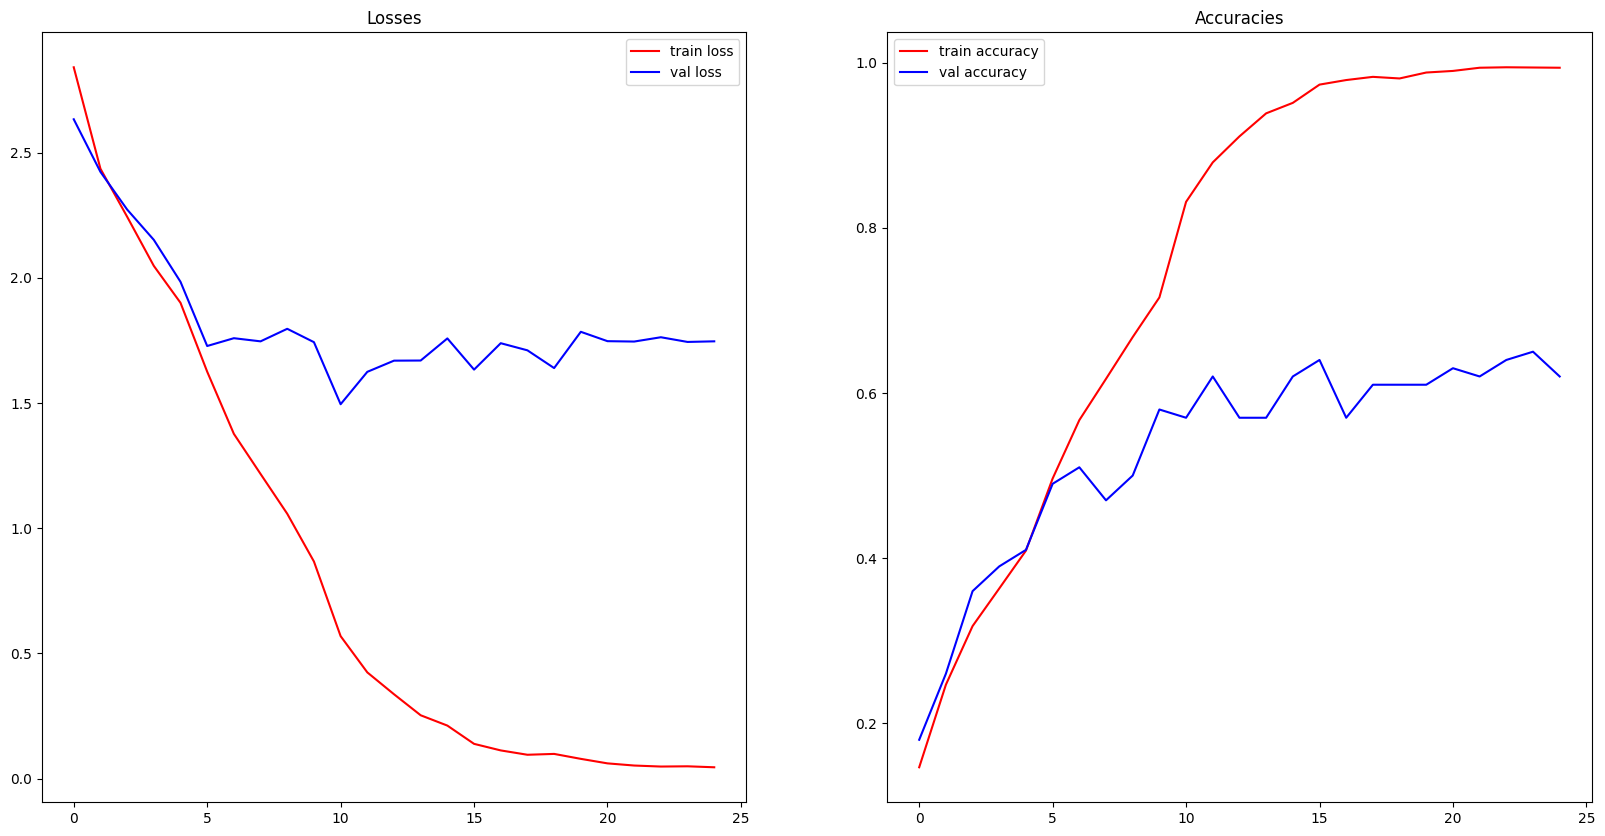

In [12]:
vit_model = ViT(
    image_size=224,
    patch_size=16,
    in_channels=3,
    embed_dim=384, # уменьшил в 2 раза
    qkv_dim=64,
    mlp_hidden_size=768, # уменьшил в 4 раза
    n_layers=6, # уменьшил в 2 раза
    n_heads=6, # уменьшил в 2 раза
    n_classes=len(train_dataset.classes),
)


N_EPOCHS = 25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = optim.Adam(vit_model.parameters(), lr=3e-4, weight_decay=1e-5)
SCHEDULER = optim.lr_scheduler.StepLR(OPTIMIZER, step_size=5, gamma=0.5)

vit_model = vit_model.to(DEVICE)
model = train_model(vit_model, train_loader, val_loader, CRITERION, OPTIMIZER, SCHEDULER, DEVICE, N_EPOCHS)


# Визуализация предсказаний

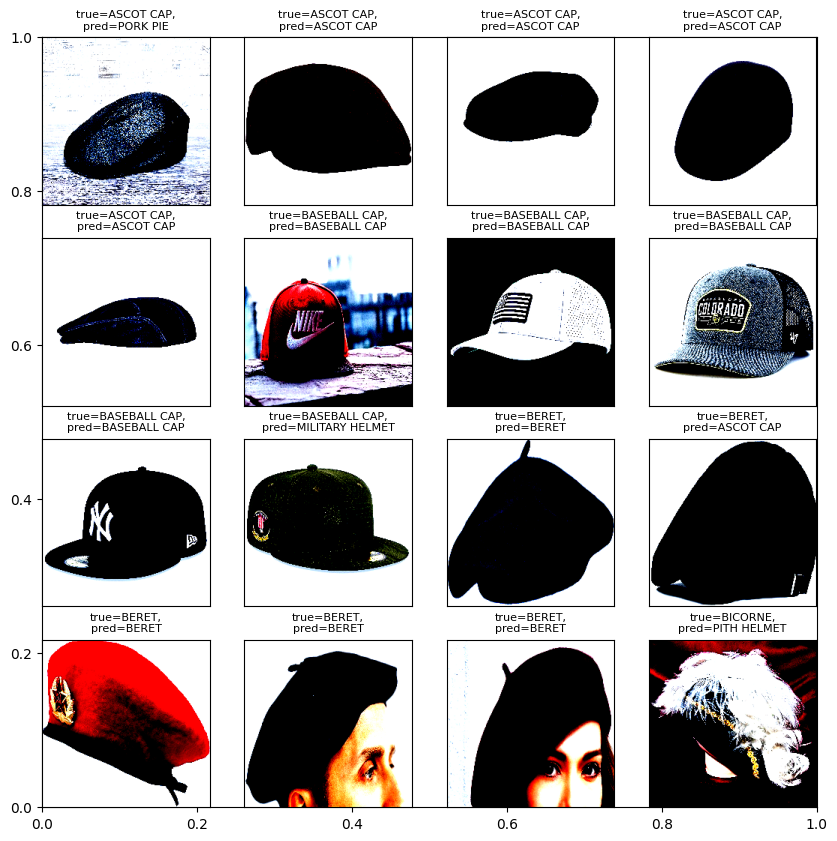

In [20]:
NUM_IMGS = 16 # число картинок для визуализации

imgs, labels = next(iter(test_loader))
imgs, labels = imgs[:NUM_IMGS], labels[:NUM_IMGS]

predictions = vit_model(imgs.to(DEVICE))
predicted_classes = torch.argmax(predictions, dim=-1)

plt.subplots(figsize=(12, 12))
for i in range(NUM_IMGS):
    plt.subplot(int(NUM_IMGS**0.5), int(NUM_IMGS**0.5), i + 1)
    plt.imshow(imgs[i].permute(1,2,0).clip(0, 1))
    true_class, pred_class = test_dataset.classes[labels[i]], test_dataset.classes[predicted_classes[i]]
    plt.title(f"true={true_class},\npred={pred_class}", fontsize=8)
    plt.xticks([])
    plt.yticks([])

plt.show()